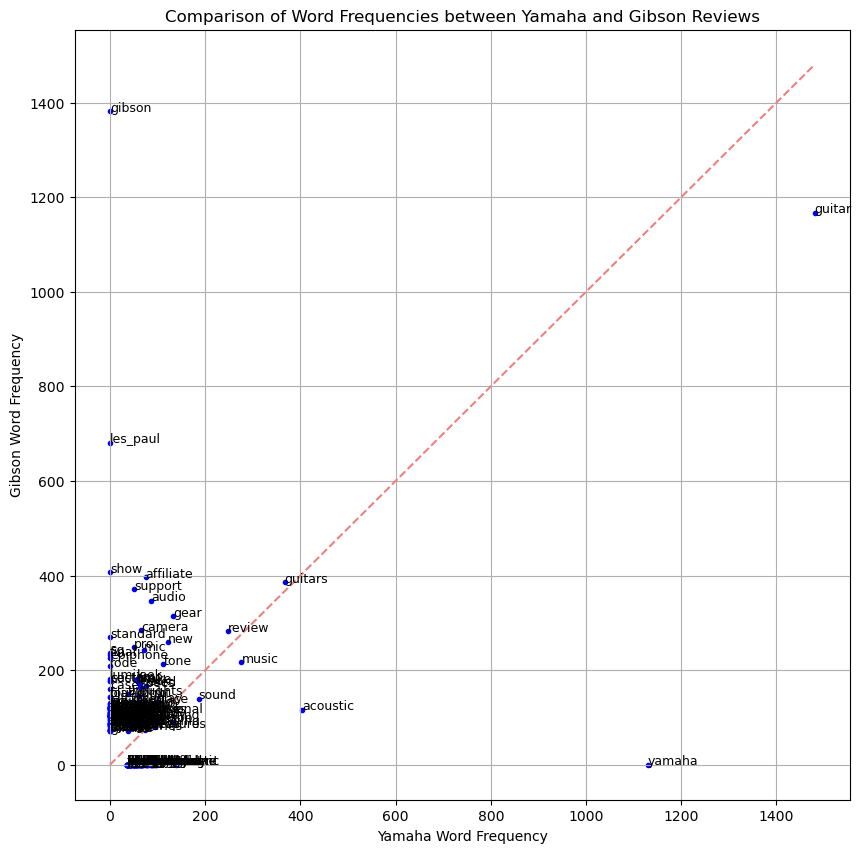

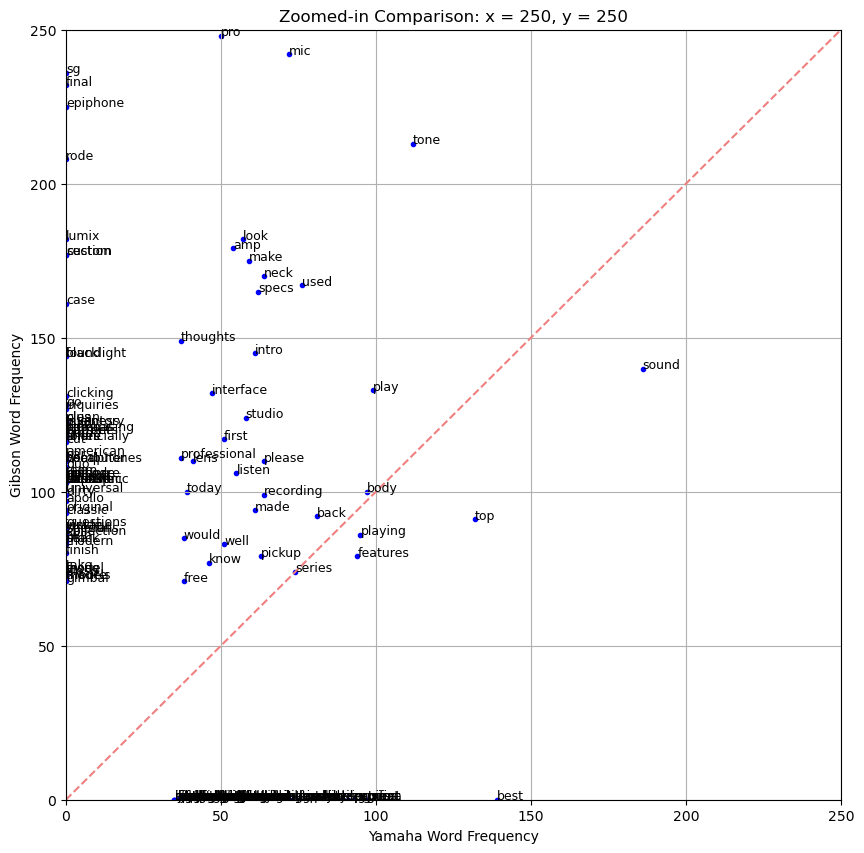

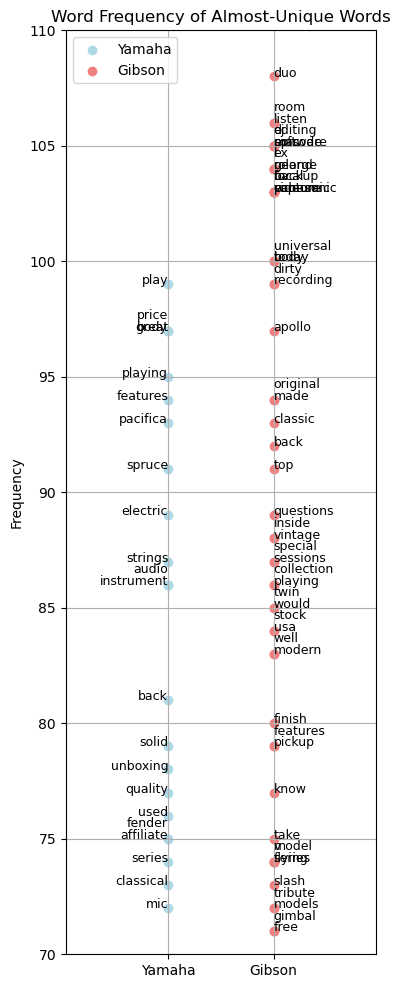

In [39]:
'''
In this problem, you will capture data that includes unstructured text and you will serve as a consultant analyzing this unstructured data using Natural Language Processing tools.
There are many choices as to how you may do this. 

Minimum specifications:
Identify a company to serve in this assignment. Their data should be part of the dataset you capture. Either...
Find an API for download, or... 

A website where you can scrape a significant number of records (say 500 scraping, 1000 API) of text and other data about your company/product/service.
Join at least two different datasets together (these could be multiple pages of web scraping or separate API requests for a product versus its competitor

Create an analysis of unstructured data for your company/product and competitors using Python:

Help us to understand what is being said about your company/product in the unstructured data (I will demo both API and screen scraping).
Use natural language processing transformers to better access the MEANING of what the users are saying (ie. Word2Vec or Doc2Vec models).
Create visuals and write explanations in a professional report that shows your findings.
'''
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
#import statsmodels.api as sm
#from googleapiclient.discovery import build
#from gensim.models.word2vec import Word2Vec
#from gensim.models.keyedvectors import KeyedVectors
import gensim.downloader as api
import nltk

# Manage workspaces via Git
current_directory = os.getcwd()
directory = ""
if current_directory[9:14] == 'vgwis':
    directory = "C:/Users/vgwis/Documents/Bana780/"
else:
    directory = "C:/Users/vgwcto/Documents/Python/Bana780/"

# Store API key locally
api_key = pd.read_csv(directory + 'key.csv').columns[0]

# Build a Function to easily search new ideas
def multiple_page_search(api_key, query, max_results = 50, max_pages = 10, cache_file = None):
    
    # Check if cache exists
    if cache_file and os.path.exists(cache_file):
        return pd.read_csv(cache_file)

    # Initialize the YouTube API client, variables
    youtube = build('youtube', 'v3', developerKey = api_key)
    descriptions = []
    next_page_token = None
    page_count = 0

    # cONSTRUCT the API request
    while page_count < max_pages:
        search = youtube.search().list(
            q = query,
            part = 'snippet',
            type = 'video',
            maxResults = max_results,
            pageToken = next_page_token
        )
        response = search.execute()

        # Collect video IDs from the response to retrieve full descriptions
        video_ids = [item['id']['videoId'] for item in response['items']]

        video_request = youtube.videos().list(
            part = 'snippet',
            id = ','.join(video_ids)
        )
        video_response = video_request.execute()

        for item in video_response['items']:
            desc = item['snippet']['description']
            descriptions.append(desc)

        # Increment the page count
        next_page_token = response.get('nextPageToken')
        page_count += 1

    # Create a DataFrame from the collected descriptions, save to cache file
    df = pd.DataFrame(descriptions, columns = ['Description'])

    if cache_file:
        df.to_csv(cache_file, index = False)

    return df

A_cache_file = directory + 'A_cache.csv'
B_cache_file = directory + 'B_cache.csv'
A_df = multiple_page_search(api_key, 'Yamaha Guitar Review', cache_file = A_cache_file)
B_df = multiple_page_search(api_key, 'Gibson Guitar Review', cache_file = B_cache_file)

df = pd.DataFrame({
    'Yamaha': A_df['Description'],
    'Gibson': B_df['Description']
})

def remove_words_containing(input, remove_list):
    input = str(input)
    for remove in remove_list:
        pattern = re.compile(r'\b\S*' + re.escape(remove) + r'\S*\b', re.IGNORECASE)
        input = pattern.sub('', input)
    filtered_text = re.sub(r'\s+', ' ', input).strip()
    return filtered_text

remove_list = ['http', 'www', 'url', '.com', '.net', '.org', '.ca', '.de', '.io', '.me', 'Subscribe', 'Follow', 'Content', 'Notification', 'Amazon', 'TikTok', 'Instagram', 'Facebook', 'Twitter', 'LinkedIn', 'Snapchat', 'Pinterest', 'Reddit', 'Tumblr', 'YouTube', 'Vimeo', 'Google', 'Paypal', 'Ebay', 'bit.ly', 'youtu.be', 'linktr.ee', 'tidd.ly', 'goo.gl', 'amzn', 'ebay', 'website', 'shop', 'store', 'buy', 'sweetwater', 'guitar-center', 'amazon', 'reverb', 'keywords', 'search', 'link', 'merch'] 

for columm in df.columns:
    df[columm] = df[columm].apply(lambda x: remove_words_containing(x, remove_list = remove_list))

#wv = api.load("word2vec-google-news-300")
#vec_king = wv['king']
#print(vec_king)
yamaha = " ".join(df['Yamaha'])
gibson = " ".join(df['Gibson'])
#print(yamaha)
#nltk.download('punkt')
#nltk.download('punkt_tab')
#nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.update(['us', 'buy', 'shop', 'get', 'like', 'check', 'links', 'link', 'demo', 'amazon', 'ebay', 'find', 'one', 'two', 'three', 'video', 'videos', 'website', 'use', 'also', 'channel', 'description', 'help', 'subscribe', 'follow', 'content', 'notification', 'social', 'media', 'platform', 'comment', 'comments', 'email', 'patreon', 'reverb', 'x', 'sweetwater', 'give', 'let', 'vs'])

#Tokenize Yamaha
y_words = nltk.word_tokenize(yamaha)
y_words = [word.lower() for word in y_words if word.isalpha()]
y_words = [word for word in y_words if word.lower() not in stop_words]
y_wordfreqs = nltk.probability.FreqDist(w.lower() for w in y_words if w not in stop_words)
y_mostcommon = y_wordfreqs.most_common(125)
y_sents = nltk.sent_tokenize(yamaha)

#Tokenize Gibson
g_words = nltk.word_tokenize(gibson)
g_words = [word.lower() for word in g_words if word.isalpha()]
g_words = [word for word in g_words if word.lower() not in stop_words]
g_words = [item.replace('les', 'les_paul') for item in g_words]
g_words = [x for x in g_words if x != 'paul']
g_wordfreqs = nltk.probability.FreqDist(w.lower() for w in g_words if w not in stop_words)
g_mostcommon = g_wordfreqs.most_common(125)
g_sents = nltk.sent_tokenize(gibson)

# Create DataFrames from the most common words then merge on word
y_df = pd.DataFrame(y_mostcommon, columns=['word', 'yamaha_count'])
g_df = pd.DataFrame(g_mostcommon, columns=['word', 'gibson_count'])
merged_df = pd.merge(y_df, g_df, on='word', how='outer').fillna(0)

# Plot the scatterplot
plt.figure(figsize=(10, 10))
plt.scatter(merged_df['yamaha_count'], merged_df['gibson_count'], color='blue', marker='.')
plt.xlabel('Yamaha Word Frequency')
plt.ylabel('Gibson Word Frequency')
plt.title('Comparison of Word Frequencies between Yamaha and Gibson Reviews')
for i in range(len(merged_df)):
    plt.text(merged_df['yamaha_count'][i], merged_df['gibson_count'][i], merged_df['word'][i], fontsize=9)

# Add diagonal line where x = y
plt.plot([0, max(merged_df['yamaha_count'].max(), merged_df['gibson_count'].max())], 
         [0, max(merged_df['yamaha_count'].max(), merged_df['gibson_count'].max())], 
         color='lightcoral', linestyle='--')

plt.grid(True)
plt.show()

# New Zoomed in Graph
plt.figure(figsize=(10, 10))
plt.xlim(0, 250)
plt.ylim(0, 250)
plt.xlabel('Yamaha Word Frequency')
plt.ylabel('Gibson Word Frequency')
plt.title('Zoomed-in Comparison: x = 250, y = 250')
for i in range(len(merged_df)):
    if merged_df['yamaha_count'][i] <= 250 and merged_df['gibson_count'][i] <= 250:
        plt.scatter(merged_df['yamaha_count'][i], merged_df['gibson_count'][i], color='blue', marker='.')
        plt.text(merged_df['yamaha_count'][i], merged_df['gibson_count'][i], merged_df['word'][i], fontsize=9)

# Add diagonal line where x = y
plt.plot([0, max(merged_df['yamaha_count'].max(), merged_df['gibson_count'].max())], 
         [0, max(merged_df['yamaha_count'].max(), merged_df['gibson_count'].max())], 
         color='lightcoral', linestyle='--')

plt.grid(True)
plt.show()

# New Graph for unique words
y_df_filtered = y_df[(y_df['yamaha_count'] < 110) & (y_df['yamaha_count'] >= 70)].reset_index(drop=True)
g_df_filtered = g_df[(g_df['gibson_count'] < 110) & (g_df['gibson_count'] >= 70)].reset_index(drop=True)
plt.figure(figsize=(4, 12))
plt.scatter([0.33] * len(y_df_filtered), y_df_filtered['yamaha_count'], color='lightblue', label='Yamaha')
plt.scatter([0.67] * len(g_df_filtered), g_df_filtered['gibson_count'], color='lightcoral', label='Gibson')

# Adjust word labels to help avoid overlap
y_positions = y_df_filtered['yamaha_count'].tolist()
adjusted_y_positions = y_positions.copy()
for i in range(1, len(adjusted_y_positions)):
    if adjusted_y_positions[i] == adjusted_y_positions[i - 1]:
        adjusted_y_positions[i] += 0.5
g_positions = g_df_filtered['gibson_count'].tolist()
adjusted_g_positions = g_positions.copy()
for i in range(1, len(adjusted_g_positions)):
    if adjusted_g_positions[i] == adjusted_g_positions[i - 1]:
        adjusted_g_positions[i] += .5

for i in range(len(y_df_filtered)):
    plt.text(0.33, adjusted_y_positions[i], y_df_filtered['word'][i], fontsize=9, ha='right')
for i in range(len(g_df_filtered)):
    plt.text(0.67, adjusted_g_positions[i], g_df_filtered['word'][i], fontsize=9, ha='left')

plt.xlabel('')
plt.ylabel('Frequency')
plt.title('Word Frequency of Almost-Unique Words')
plt.xlim(0, 1)
plt.ylim(70, 110)
plt.xticks([0.33, 0.67], ['Yamaha', 'Gibson'])

plt.legend()
plt.grid(True)
plt.show()